# Tutorial Q1 - Qubit rotation

This tutorial demonstrates PennyLane's "hello-world" example for qubit-based architectures with the projectq backend. 

The task is to optimize two rotation gates in order to flip a single qubit from state $|0\rangle$ to state $|1\rangle $. 

## Imports

First we need to import Penny Lane, as well as Penny Lane's version of numpy. This allows us to automatically compute gradients for functions that manipulate numpy arrays, including quantum functions. We also want to compare two optimizers, basic gradient descent and adagrad.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer, AdagradOptimizer

Next, use the default simulator as a "device" to run the quantum node. We only need a single quantum wire.

In [2]:
dev = qml.device('default.qubit', wires=1)

## Quantum node

We define a quantum node called "circuit". The decorator `qml.qnode(dev)` that saves us to create a quantum node via `circuit = qml.qnode.QNode(circuit, dev)`. 

In [3]:
@qml.qnode(dev)
def circuit(var):

    qml.RX(var[0], wires=[0])
    qml.RY(var[1], wires=[0])
    
    return qml.expval.PauliZ(0)

This function uses Penny Lane to run the following quantum circuit:

<img src="figures/rotation_circuit.png">

Starting with a qubit in the ground state, 

$$ |0\rangle = \begin{pmatrix}1 \\ 0 \end{pmatrix}, $$

we first rotate the qubit around the x-axis by 
$$R_x(v_1) = e^{-iv_1 X /2} = 
\begin{pmatrix} \cos \frac{v_1}{2} &  -i \sin \frac{v_1}{2} \\  
                -i \sin \frac{v_1}{2} &  \cos \frac{v_1}{2} 
\end{pmatrix}, $$ 
               
and then around the y-axis by 
$$ R_y(v_2) = e^{-i v_2 Y/2} = 
\begin{pmatrix} \cos \frac{v_2}{2} &  - \sin \frac{v_2}{2} \\  
                \sin \frac{v_2}{2} &  \cos \frac{v_2}{2} 
\end{pmatrix}. $$ 

After these operations the qubit is in the state

$$ | \psi \rangle = R_y(v_1) R_x(v_2) | 0 \rangle $$

Finally, we measure the expectation $ \langle \psi | Z | \psi \rangle $ of the Pauli-Z operator 
$$Z = 
\begin{pmatrix} 1 &  0 \\  
                0 & -1 
\end{pmatrix}. $$ 


Depending on the circuit parameters $v_1$ and $v_2$, the output expectation lies between $1$ (if $| \psi \rangle = | 0  \rangle $) and $-1$ (if $| \psi \rangle = | 1  \rangle $).

## Objective

Next, we define a cost. Here, the cost is directly the expectation of the PauliZ measurement, so that the cost is trivially the output of the circuit.

In [4]:
def objective(var):
    return circuit(var)

With this objective, the optimization procedure is supposed to find the weights that rotate the qubit from the ground state 

 <img src="figures/bloch_before.png" width="250"> 
 
 to the excited state
 
 <img src="figures/bloch_after.png" width="250">
 
 The rotation gates give the optimization landscape a trigonometric shape with four global minima and five global maxima. 
 
 *Note: To run the following cell you need the matplotlib library.*

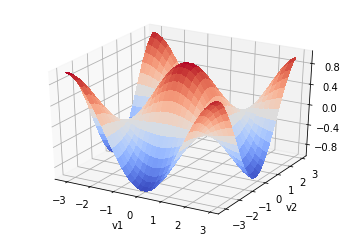

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
%matplotlib inline

fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.arange(-3.1, 3.1, 0.2)
Y = np.arange(-3.1, 3.1, 0.2)
length = len(X)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(length, length)
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.show()

## Optimization

The initial values of the x- and y-rotation parameters $v_1, v_2$ are set to near-zero. This corresponds to identity gates, in other words, the circuit leaves the qubit in the ground state.

In [6]:
var_init = np.array([0.011, 0.012])

The value of the objective at the initial point is close to $1$.

In [7]:
objective(var_init)

0.9998675058299387

We choose a simple Gradient Descent Optimizer and update the weights for 10 steps. The final parameters correspond to a $Z$ expectation of nearly $-1$, which means that the qubit is flipped.

In [8]:
gd = GradientDescentOptimizer(0.4)


var = var_init
var_gd = [var]

for it in range(100):
    var = gd.step(objective, var)

    if (it+1) % 5 == 0:
        var_gd.append(var)
        print('Objective after step {:5d}: {: .7f}'.format(it+1, objective(var)) )

print('\nOptimized rotation angles: {}'.format(var))

Objective after step     5:  0.9961778
Objective after step    10:  0.8974944
Objective after step    15:  0.1440490
Objective after step    20: -0.1536720
Objective after step    25: -0.9152496
Objective after step    30: -0.9994046
Objective after step    35: -0.9999964
Objective after step    40: -1.0000000
Objective after step    45: -1.0000000
Objective after step    50: -1.0000000
Objective after step    55: -1.0000000
Objective after step    60: -1.0000000
Objective after step    65: -1.0000000
Objective after step    70: -1.0000000
Objective after step    75: -1.0000000
Objective after step    80: -1.0000000
Objective after step    85: -1.0000000
Objective after step    90: -1.0000000
Objective after step    95: -1.0000000
Objective after step   100: -1.0000000

Optimized rotation angles: [5.76516144e-17 3.14159265e+00]


Starting at a different offset, we train another optimizer called Adagrad, which improves on gradient descent.

*Note: Adagrad, a many other optimizers, has internal hyperparameters that are stored in the optimizer instance (here: `ada`). To reset these hyperparameters, use `ada.reset()`.*

In [9]:
ada = AdagradOptimizer(0.4)

var = np.array([-0.011, 0.012])
var_ada = [var]

for it in range(100):
    var = ada.step(objective, var)
    
    if (it+1) % 5 == 0:
        var_ada.append(var)
        print('Objective after step {:5d}: {: .7f}'.format(it+1, objective(var)) )

print('\nOptimized rotation angles: {}'.format(var))

Objective after step     5:  0.0123798
Objective after step    10: -0.0000052
Objective after step    15: -0.0008878
Objective after step    20: -0.0535320
Objective after step    25: -0.7042678
Objective after step    30: -0.9855194
Objective after step    35: -0.9994782
Objective after step    40: -0.9999814
Objective after step    45: -0.9999993
Objective after step    50: -1.0000000
Objective after step    55: -1.0000000
Objective after step    60: -1.0000000
Objective after step    65: -1.0000000
Objective after step    70: -1.0000000
Objective after step    75: -1.0000000
Objective after step    80: -1.0000000
Objective after step    85: -1.0000000
Objective after step    90: -1.0000000
Objective after step    95: -1.0000000
Objective after step   100: -1.0000000

Optimized rotation angles: [-8.36813259e-12  3.14159265e+00]


Adagrad and gradient descent find the same minimum, and, since neither has information on second order derivatives, both take a detour through a saddle point. However, Adagrad takes considerably fewer steps.

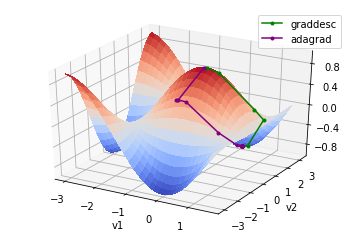

In [10]:
fig = plt.figure(figsize = (6, 4))
ax = fig.gca(projection='3d')

X = np.linspace(-3, 1.6, 30)
Y = np.linspace(-3, 3, 30)
xx, yy = np.meshgrid(X, Y)
Z = np.array([[objective([x, y]) for x in X] for y in Y]).reshape(len(Y), len(X))
surf = ax.plot_surface(xx, yy, Z, cmap=cm.coolwarm, antialiased=False)

path_z = [objective(var)+1e-8 for var in var_gd]
path_x = [v[0] for v in var_gd]
path_y = [v[1] for v in var_gd]
ax.plot(path_x, path_y, path_z, c='green', marker='.', label="graddesc")

path_z = [objective(var)+1e-8 for var in var_ada]
path_x = [v[0] for v in var_ada]
path_y = [v[1] for v in var_ada]
ax.plot(path_x, path_y, path_z, c='purple', marker='.', label="adagrad")

ax.set_xlabel("v1")
ax.set_ylabel("v2")
ax.zaxis.set_major_locator(MaxNLocator(nbins = 5, prune = 'lower'))

plt.legend()
plt.show()

### Choosing initial variables

The variables are best randomly initialized with near-zero values. To show why constant initializations can go wrong, consider starting at exactly zero. 

In [11]:
var = np.array([0., 0.])

for it in range(100):
    var = gd.step(objective, var)
    if (it+1) % 5 == 0:
        print('Objective after step {:5d}: {: .7f}'.format(it+1, objective(var)) )

Objective after step     5:  1.0000000
Objective after step    10:  1.0000000
Objective after step    15:  1.0000000
Objective after step    20:  1.0000000
Objective after step    25:  1.0000000
Objective after step    30:  1.0000000
Objective after step    35:  1.0000000
Objective after step    40:  1.0000000
Objective after step    45:  1.0000000
Objective after step    50:  1.0000000
Objective after step    55:  1.0000000
Objective after step    60:  1.0000000
Objective after step    65:  1.0000000
Objective after step    70:  1.0000000
Objective after step    75:  1.0000000
Objective after step    80:  1.0000000
Objective after step    85:  1.0000000
Objective after step    90:  1.0000000
Objective after step    95:  1.0000000
Objective after step   100:  1.0000000


The model is "stuck" in the maximum of the cost function where the gradient vanishes.